# Enrichment for genes DE between neighbouring stages
Genes whose expression changes strongly between two neighbouring stages were selected with two different methods (described below). These methods also ensure that genes do not change between many neighbouring stages.

In [1]:
import os
import sys
from importlib import reload

module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.insert(0,module_path)
    
import warnings

import pandas as pd
from IPython.display import display
pd.set_option('max_colwidth', 70)
pd.set_option('display.max_rows', 500)
import string
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
matplotlib.rcParams.update({'figure.max_open_warning': 0})

from orangecontrib.bioinformatics.geneset.__init__ import list_all

import jupyter_functions as jf
reload(jf)
import jupyter_functions as jf
from networks.functionsDENet import loadPickle, savePickle
import stages_DE.enrichment_library as enr
reload(enr)
import stages_DE.enrichment_library as enr

In [2]:
#Path for expression data (mergedGenes_RPKUM.tsv)
#path_main='/home/karin/Documents/'
path_main='/home/khrovatin/'
dataPath=path_main+'timeTrajectories/data/RPKUM/combined/'
#Path for results
pathImpulse=path_main+'timeTrajectories/data/stages/DE_across_stages/'
pathDeseq=path_main+'timeTrajectories/data/deTime/neighbouring/'
path_save=path_main+'timeTrajectories/data/enrichment/milestones/'

## Used gene sets
Use gene sets that do not have less than 5 or more than 500 genes. Use all ontologies.

In [3]:
# For conversion of gene names to EID
genes = pd.read_csv(dataPath + 'mergedGenes_RPKUM.tsv', sep='\t', index_col=0)
all_gene_names= genes[(genes != 0).any(axis=1)].index
NAME_EID=enr.name_genes_entrez(gene_names=all_gene_names, key_entrez=False)
ALL_GENE_NAMES_EID=enr.convert_EID(genes=all_gene_names, name_EID=NAME_EID)

In [4]:
# Get all gene sets
gene_sets=list(list_all(organism='44689'))
GENE_SETS_ONTOLOGY=enr.get_gene_sets(gene_set_names=gene_sets, go_slims=True,set_sizes=(5,500),
                                    reference = ALL_GENE_NAMES_EID)
# Remove unused gene sets
del GENE_SETS_ONTOLOGY[('Dictybase', 'Phenotypes')]

# Find out max/min gene set sizes and N sets
max_n=0
min_n=np.inf
for k,v in GENE_SETS_ONTOLOGY.items():
    for s in v:
        n=len(s.genes & ALL_GENE_NAMES_EID)
        if n<min_n:
            min_n=n
        if n>max_n:
            max_n=n
print('Min size',min_n,'Max size',max_n)  
print('N sets',{k:len(v) for k,v in GENE_SETS_ONTOLOGY.items()})

Min size 5 Max size 495
N sets {('Custom', 'Baylor'): 15, ('GO', 'molecular_function'): 35, ('KEGG', 'Pathways'): 95, ('GO', 'biological_process'): 52, ('GO', 'cellular_component'): 24}


## Enrichment report

In [5]:
#Result filtering
MAX_FDR_DE=0.01
MIN_ABS_LFC_DE=2
MAX_N_SIGNIFICANT_DE=2
#Enrichment
PADJ=0.25
MIN_OVERLAP=2
MAX_FE_BAR=None
MIN_FDR_BAR=10**(-10)
LFDR_BASE_BAR=10
# Any colour map from https://matplotlib.org/tutorials/colors/colormaps.html
#CMAP_FDR_BAR='gnuplot'
CMAP_FDR_BAR=['#bede57','#5fb526','#36801d','#015713','#000803']

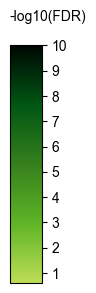

In [6]:
#Colour fold change legend
%matplotlib agg
fig,ax=enr.plot_legend_enrichment_bar(cmap=CMAP_FDR_BAR, min_FDR=MIN_FDR_BAR,used_padj=PADJ,base=LFDR_BASE_BAR)
plt.savefig(path_save+'legend.pdf',bbox_inches='tight')
display(fig)

In [8]:
# Load data
#data_deseq=pd.read_table(pathDeseq+'WT/combined.tsv',index_col=0)
#data_impulse=pd.read_table(pathImpulse+'DEacrossStages_summary_mainstage_WT_0.001.tsv',index_col=0)
#data=pd.concat([data_deseq,data_impulse],sort=True,axis=1)

#data_deseq_AX4=pd.read_table(pathDeseq+'AX4/combined.tsv',index_col=0)
data_impulse_AX4=pd.read_table(pathImpulse+'DEacrossStages_summary_mainstage_AX4_0.001.tsv',index_col=0)
#data_AX4=pd.concat([data_deseq_AX4,data_impulse_AX4],sort=True,axis=1)

data_deseq_AX4_keepNA=pd.read_table(pathDeseq+'AX4_keepNA/combined.tsv',index_col=0)
data_AX4_keepNA=pd.concat([data_deseq_AX4_keepNA,data_impulse_AX4],sort=True,axis=1)

In [11]:
#Extracts comparisons form DESeq2 results. Assumes that the same are present in Impulse
COMPARISONS=[comparison.replace('_FDR_overall','') for comparison in data_AX4_keepNA.columns[
    data_AX4_keepNA.columns.str.contains('_FDR_overall')]]

In [ ]:
#Count N significant comparisons
#for gene in data.index:
#    data_gene = data.loc[gene, :]
#    significant = 0
#    for comparison in COMPARISONS:
#        # Stages were compared
#        if data_gene.index.str.contains(comparison).any():
#            if abs(data_gene[comparison + '_log2FoldChange']) >= MIN_ABS_LFC_DE and data_gene[
#                comparison + '_FDR_overall'] <= MAX_FDR_DE:
#                significant += 1
#    data.loc[gene, 'Significant_N'] = significant


### Filtering by restricting N of DE neighbouring stages
The genes for each pair of neighbouring stages are obtained with the following two filters:
1.) Gene is DE between two neighbouring stages, based on abs lFC (e.g. >=2) and FDR (e.g. <=0.01).
2.) Gene is not DE according to the above criteria in more than 2 neighbouring stages.

Old main stage data! TODO: update main stage data.

In [ ]:
%matplotlib agg
figs=[]
for comparison in COMPARISONS:
    query_names=list(data.query('abs(' + comparison + '_log2FoldChange) >= ' + str(MIN_ABS_LFC_DE) +
                      ' & ' + comparison + '_FDR_overall <=' + str(MAX_FDR_DE) +
                      '& Significant_N <=' + str(MAX_N_SIGNIFICANT_DE)).index)

    enriched=enr.group_diff_enrichment(query_names=query_names,
                                       group=comparison,
                                       name_eid=NAME_EID,all_gene_names_eid=ALL_GENE_NAMES_EID, 
                                       gene_sets_ontology=GENE_SETS_ONTOLOGY,
                                       use_annotated_genes=True,
                                       min_overlap=MIN_OVERLAP,padj=PADJ,
                                       make_enrichment_bar=True,
                                       max_FE_bar=MAX_FE_BAR, min_FDR_bar=MIN_FDR_BAR,cmap_FDR_bar=CMAP_FDR_BAR,
                                       lFDR_base_bar=LFDR_BASE_BAR
                                      )
    figs.append(enriched[1])
    display(enriched[1][0])
plt.close('all')    

### Filtering by using stages identified as transitions by ImpulseDE2 on AX4
The genes for each pair of neighbouring stages are obtained with the following two filters:
1.) Gene is DE between two neighbouring stages, based on abs lFC (e.g. >=2, reported separately for up/down regulation) and FDR (e.g. <=0.01).
2.) ImpulseDE2 identified gene as DE expressed through stages and the transition occured between the two neighbouring stages.

!! OLD analysis - genes excluded by independent filtering for each comparison were not included!

In [ ]:
%matplotlib agg
figs=[]
for comparison in COMPARISONS:
    for lFC_filter in ['>= ','<= -']:
        query_names=list(data_AX4.query( comparison + '_log2FoldChange ' +lFC_filter+ str(MIN_ABS_LFC_DE) +
                          ' & ' + comparison + '_FDR_overall <= ' + str(MAX_FDR_DE) +
                          ' & ' + comparison + ' == 1').index)
        comparison_title=comparison+' lFC '+lFC_filter+ str(MIN_ABS_LFC_DE)+' and FDR_overall <= ' + str(MAX_FDR_DE)
        if(len(query_names)>0):
            enriched=enr.group_diff_enrichment(query_names=query_names,
                                               group=comparison_title,
                                               name_eid=NAME_EID,all_gene_names_eid=ALL_GENE_NAMES_EID, 
                                               gene_sets_ontology=GENE_SETS_ONTOLOGY,
                                               use_annotated_genes=True,
                                               min_overlap=MIN_OVERLAP,padj=PADJ,
                                               make_enrichment_bar=True,
                                               max_FE_bar=MAX_FE_BAR, min_FDR_bar=MIN_FDR_BAR,cmap_FDR_bar=CMAP_FDR_BAR,
                                               lFDR_base_bar=LFDR_BASE_BAR
                                              )
            figs.append(enriched[1])
            display(enriched[1][0])
        else:
            print('***  '+comparison_title+' selected: 0\n')
plt.close('all')  

NEW analysis (not excluding genes that were filtered out by independent DESeq2 analysis).

***  no_agg_stream lFC >= 2 and FDR_overall <= 0.01 selected: 247 with EID: 246
Genes annotated with a gene set in reference 36.6% and group 29.0%
Enrichment at FDR: 0.25 and min group - gene set overlap 2
N group genes in displayed gene sets: 17 out of 72 group genes used for enrichment calculation.


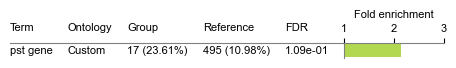

***  no_agg_stream lFC <= -2 and FDR_overall <= 0.01 selected: 294 with EID: 292
Genes annotated with a gene set in reference 36.6% and group 45.0%
Enrichment at FDR: 0.25 and min group - gene set overlap 2
N group genes in displayed gene sets: 87 out of 132 group genes used for enrichment calculation.


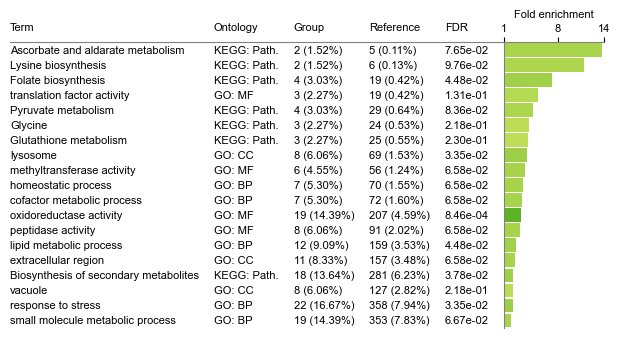

***  stream_lag lFC >= 2 and FDR_overall <= 0.01 selected: 71 with EID: 70
Genes annotated with a gene set in reference 36.6% and group 37.0%
Enrichment at FDR: 0.25 and min group - gene set overlap 2
N group genes in displayed gene sets: 0 out of 26 group genes used for enrichment calculation.


None

***  stream_lag lFC <= -2 and FDR_overall <= 0.01 selected: 1 with EID: 1
Genes annotated with a gene set in reference 36.6% and group 0.0%
Enrichment at FDR: 0.25 and min group - gene set overlap 2
N group genes in displayed gene sets: 0 out of 0 group genes used for enrichment calculation.


None

***  lag_tag lFC >= 2 and FDR_overall <= 0.01 selected: 260 with EID: 259
Genes annotated with a gene set in reference 36.6% and group 51.0%
Enrichment at FDR: 0.25 and min group - gene set overlap 2
N group genes in displayed gene sets: 101 out of 133 group genes used for enrichment calculation.


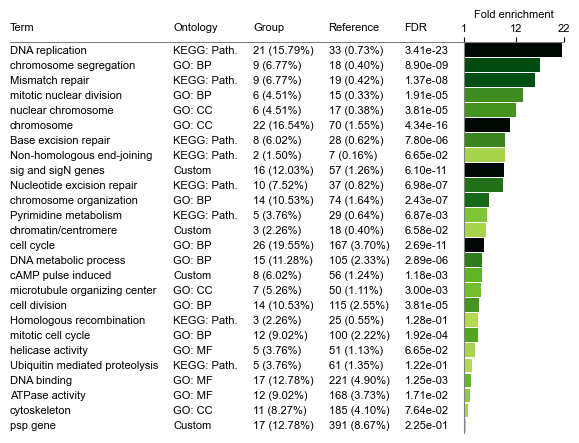

***  lag_tag lFC <= -2 and FDR_overall <= 0.01 selected: 11 with EID: 11
Genes annotated with a gene set in reference 36.6% and group 18.0%
Enrichment at FDR: 0.25 and min group - gene set overlap 2
N group genes in displayed gene sets: 0 out of 2 group genes used for enrichment calculation.


None

***  tag_tip lFC >= 2 and FDR_overall <= 0.01 selected: 35 with EID: 35
Genes annotated with a gene set in reference 36.6% and group 60.0%
Enrichment at FDR: 0.25 and min group - gene set overlap 2
N group genes in displayed gene sets: 20 out of 21 group genes used for enrichment calculation.


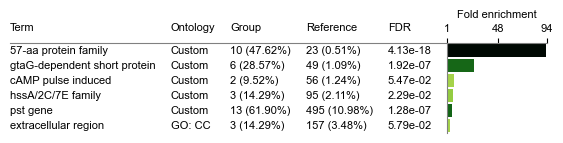

***  tag_tip lFC <= -2 and FDR_overall <= 0.01 selected: 20 with EID: 20
Genes annotated with a gene set in reference 36.6% and group 45.0%
Enrichment at FDR: 0.25 and min group - gene set overlap 2
N group genes in displayed gene sets: 6 out of 9 group genes used for enrichment calculation.


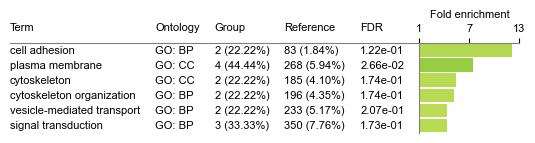

***  tip_slug lFC >= 2 and FDR_overall <= 0.01 selected: 12 with EID: 12
Genes annotated with a gene set in reference 36.6% and group 100.0%
Enrichment at FDR: 0.25 and min group - gene set overlap 2
N group genes in displayed gene sets: 9 out of 12 group genes used for enrichment calculation.


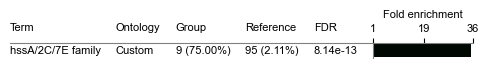

***  tip_slug lFC <= -2 and FDR_overall <= 0.01 selected: 0

***  slug_mhat lFC >= 2 and FDR_overall <= 0.01 selected: 209 with EID: 209
Genes annotated with a gene set in reference 36.6% and group 46.0%
Enrichment at FDR: 0.25 and min group - gene set overlap 2
N group genes in displayed gene sets: 52 out of 96 group genes used for enrichment calculation.


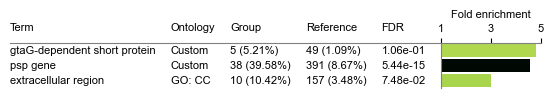

***  slug_mhat lFC <= -2 and FDR_overall <= 0.01 selected: 0

***  mhat_cul lFC >= 2 and FDR_overall <= 0.01 selected: 45 with EID: 45
Genes annotated with a gene set in reference 36.6% and group 29.0%
Enrichment at FDR: 0.25 and min group - gene set overlap 2
N group genes in displayed gene sets: 4 out of 13 group genes used for enrichment calculation.


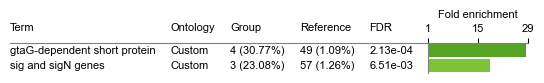

***  mhat_cul lFC <= -2 and FDR_overall <= 0.01 selected: 9 with EID: 9
Genes annotated with a gene set in reference 36.6% and group 78.0%
Enrichment at FDR: 0.25 and min group - gene set overlap 2
N group genes in displayed gene sets: 7 out of 7 group genes used for enrichment calculation.


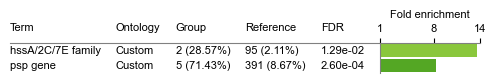

***  cul_FB lFC >= 2 and FDR_overall <= 0.01 selected: 176 with EID: 175
Genes annotated with a gene set in reference 36.6% and group 29.0%
Enrichment at FDR: 0.25 and min group - gene set overlap 2
N group genes in displayed gene sets: 25 out of 50 group genes used for enrichment calculation.


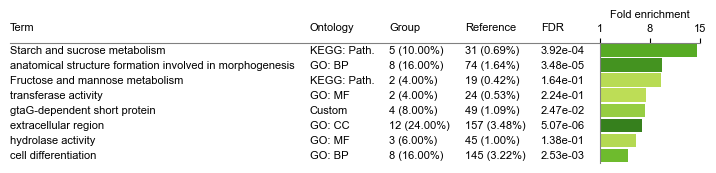

***  cul_FB lFC <= -2 and FDR_overall <= 0.01 selected: 3 with EID: 3
Genes annotated with a gene set in reference 36.6% and group 67.0%
Enrichment at FDR: 0.25 and min group - gene set overlap 2
N group genes in displayed gene sets: 0 out of 2 group genes used for enrichment calculation.


None

In [12]:
%matplotlib agg
figs=[]
for comparison in COMPARISONS:
    for lFC_filter in ['>= ','<= -']:
        query_names=list(data_AX4_keepNA.query( comparison + '_log2FoldChange ' +lFC_filter+ str(MIN_ABS_LFC_DE) +
                          ' & ' + comparison + '_FDR_overall <= ' + str(MAX_FDR_DE) +
                          ' & ' + comparison + ' == 1').index)
        comparison_title=comparison+' lFC '+lFC_filter+ str(MIN_ABS_LFC_DE)+' and FDR_overall <= ' + str(MAX_FDR_DE)
        if(len(query_names)>0):
            enriched=enr.group_diff_enrichment(query_names=query_names,
                                               group=comparison_title,
                                               name_eid=NAME_EID,all_gene_names_eid=ALL_GENE_NAMES_EID, 
                                               gene_sets_ontology=GENE_SETS_ONTOLOGY,
                                               use_annotated_genes=True,
                                               min_overlap=MIN_OVERLAP,padj=PADJ,
                                               make_enrichment_bar=True,
                                               max_FE_bar=MAX_FE_BAR, min_FDR_bar=MIN_FDR_BAR,cmap_FDR_bar=CMAP_FDR_BAR,
                                               lFDR_base_bar=LFDR_BASE_BAR
                                              )
            figs.append(enriched[1])
            
            plt.savefig(path_save+comparison_title+'.pdf')
            display(enriched[1][0])
        else:
            print('***  '+comparison_title+' selected: 0\n')
plt.close('all')  

In [ ]:
# Save gene list
result=pd.DataFrame()
for comparison in COMPARISONS:
    for lFC_filter in ['>= ','<= -']:
        query_names=list(data_AX4_keepNA.query( comparison + '_log2FoldChange ' +lFC_filter+ str(MIN_ABS_LFC_DE) +
                          ' & ' + comparison + '_FDR_overall <= ' + str(MAX_FDR_DE) +
                          ' & ' + comparison + ' == 1').index)
        n_genes=len(query_names)
        if lFC_filter == '>= ':
            d='up'
        else:
            d='down'
        result=pd.concat([result,pd.DataFrame({'Gene':query_names,
                                              'Comparison':[comparison]*n_genes,
                                             'Direction':[d]*n_genes})],ignore_index=True)
        

result.to_csv(pathImpulse+'milestoneNeighboursFiltered_lFC'+str(MIN_ABS_LFC_DE)+'padj'+str(MAX_FDR_DE)+'.tsv',
              sep='\t',index=False)